In [1]:
import scvi
import os
import tempfile
import scanpy as sc
import seaborn as sns
import torch
import pandas as pd
from rich import print
import numpy as np
import matplotlib.pyplot as plt
import skmisc

/home/users/allstaff/moore.z/.conda/envs/scvi-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scvi.settings.seed = 42

[rank: 0] Global seed set to 42


In [3]:
torch.set_float32_matmul_precision('high')

In [4]:
adata = sc.read("/vast/scratch/users/moore.z/pdo_compar/data/intermed/1_seurat_all_tumour_anndata.h5ad")
adata.X = adata.layers["counts"]

In [5]:
from scipy import sparse

sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X

In [6]:
# integration with scVI
scvi.model.SCVI.setup_anndata(
    adata = adata, 
    batch_key = "sample"
)
# create model
scvi_model = scvi.model.SCVI(
    adata = adata,
    n_hidden = 128,
    n_latent = 50,
    dispersion = "gene-batch"
)
scvi.settings.seed = 42
# train model 
scvi_model.train(
    max_epochs = 1000, 
    early_stopping = True,
    accelerator = "gpu"
)

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 498/1000:  50%|████▉     | 498/1000 [08:23<08:27,  1.01s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=1.8e+3] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1861.865. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

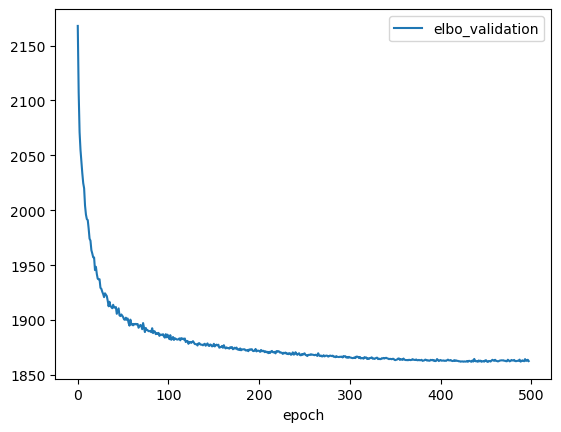

In [7]:
scvi_model.history["elbo_validation"].plot()

In [8]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [9]:
sc.pp.neighbors(
    adata = adata, 
    use_rep = SCVI_LATENT_KEY, 
    n_neighbors = 15,
    n_pcs = 50,
    method = "gauss",
    knn = False
)
sc.tl.leiden(
    adata,
    flavor = "igraph",
    resolution = 1,
    n_iterations = 10
)

In [10]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/home/users/allstaff/moore.z/.conda/envs/scvi-env/lib/python3.12/site-packages/matplotlib/colors.py:1404: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


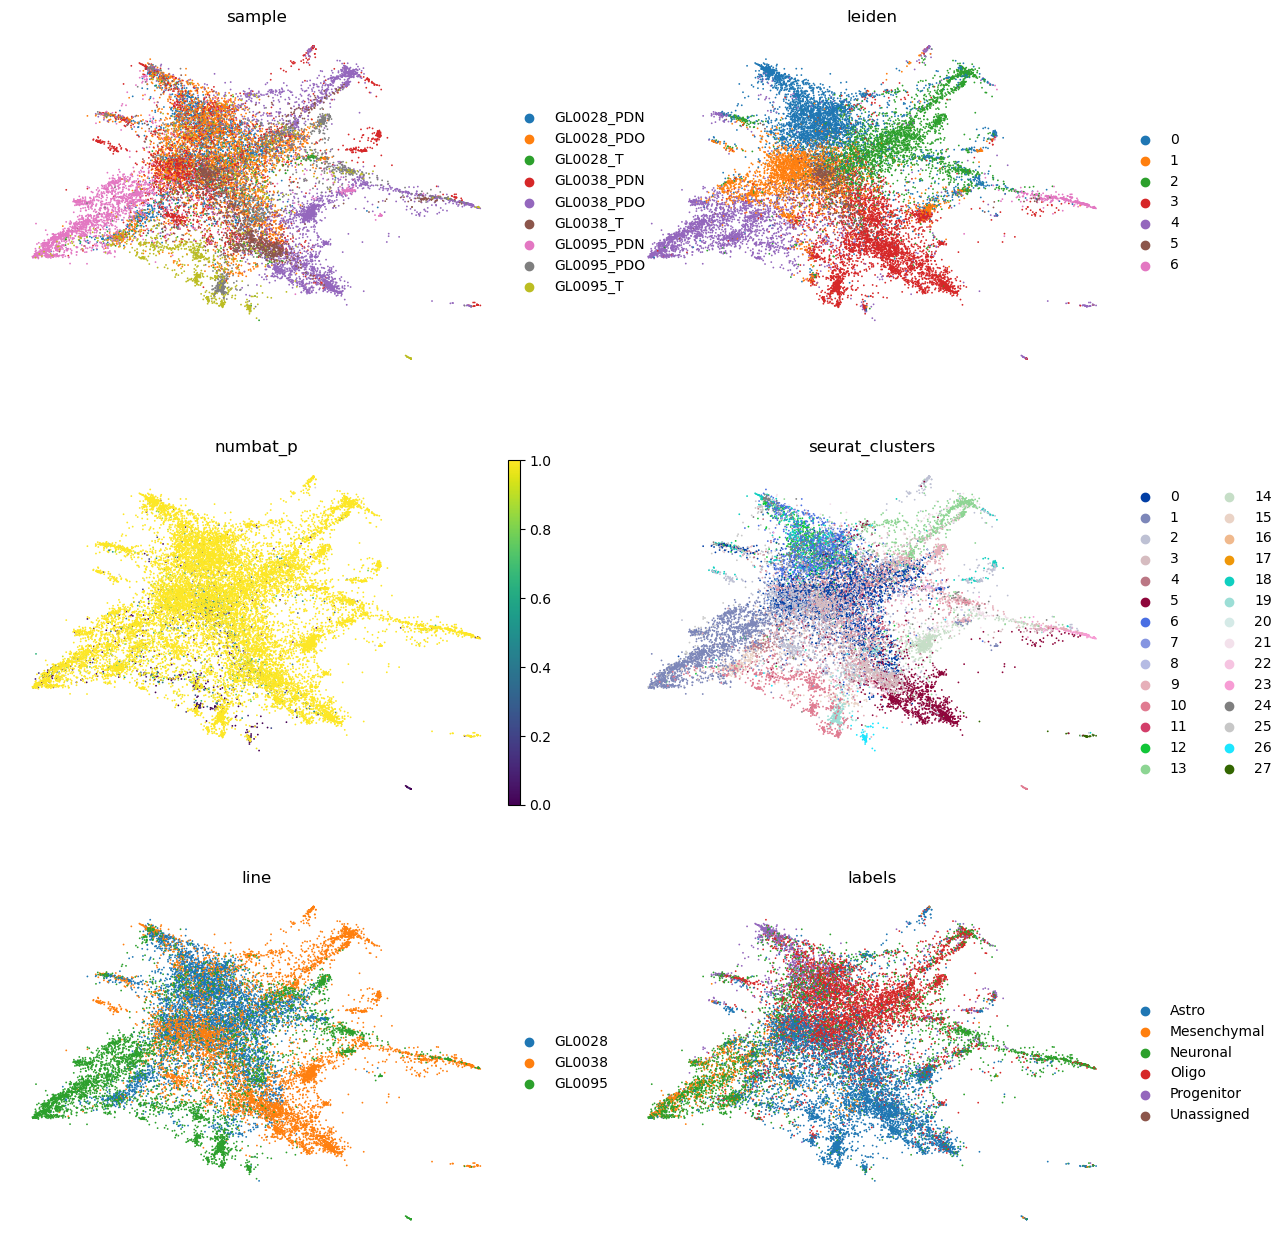

In [11]:
sc.pl.embedding(
    adata = adata,
    basis = SCVI_MDE_KEY,
    color = ["sample", "leiden", "numbat_p", "seurat_clusters", "line", "labels"],
    frameon = False,
    ncols = 2
)

In [14]:
adata.write_h5ad("/vast/scratch/users/moore.z/pdo_compar/data/intermed/snrnaseq/scvi_all_integrated_tumour.h5ad")

In [15]:
import scipy as sp
dist = adata.obsp["distances"]
dist = pd.DataFrame(dist)
dist
dist.to_csv(path_or_buf="/vast/scratch/users/moore.z/pdo_compar/data/intermed/snrnaseq/distances.csv")

In [11]:
# integration with scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(
    adata = adata, 
    batch_key = "sample"
)
# create model
scvi_model = scvi.model.SCVI(
    adata = adata,
    n_hidden = 128,
    n_latent = 50,
    dispersion = "gene-batch"
)
# train model 
# model.train()
# scvi.settings.dl_num_workers = 11
scvi_model.train(
    max_epochs = 1000, 
    early_stopping = True,
    accelerator = "gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 512/1000:  51%|█████     | 512/1000 [10:56<10:25,  1.28s/it, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.68e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1735.451. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

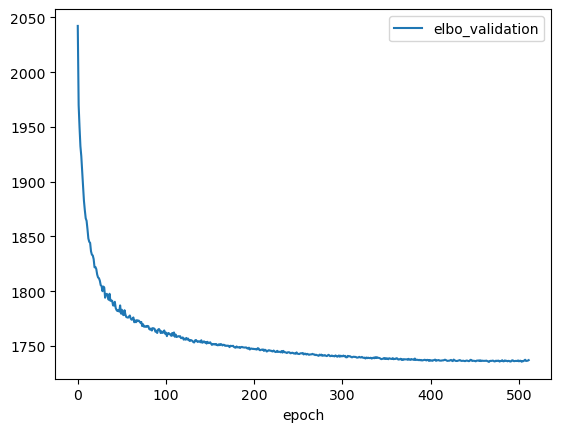

In [12]:
scvi_model.history["elbo_validation"].plot()

In [13]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [14]:
sc.pp.neighbors(
    adata = adata, 
    use_rep = SCVI_LATENT_KEY, 
    n_neighbors = 15,
    n_pcs = 50
)
sc.tl.leiden(
    adata,
    flavor = "igraph",
    resolution = 1,
    n_iterations = 10
)

In [15]:
adata

AnnData object with n_obs × n_vars = 22639 × 5000
    obs: 'bc_wells', 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'sizeFactor', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'low_lib_size', 'low_n_features', 'high_subsets_mito_percent', 'discard', 'discard_mito', 'discard_detected', 'discard_final', 'individual_anno', 'score_g1', 'score_g2m', 'score_s', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_id', 'gene_name', 'genome', 'gene_version', 'gene_source', 'gene_biotype', 'n_cells'
    uns: 'X_name', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden'
    obsm: 'X_scVI'
    layers: 'logcounts'
    obsp: 'distances', 'connectivities'

In [16]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


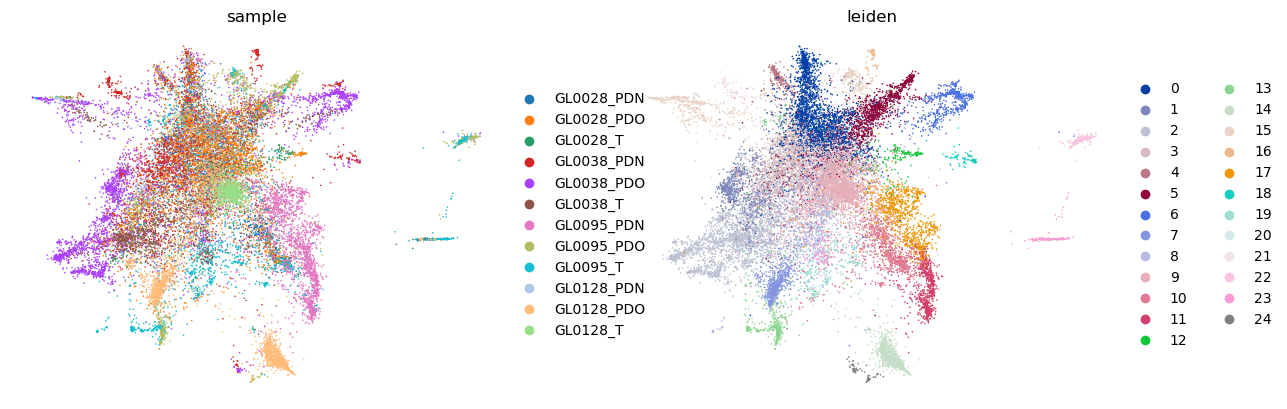

In [17]:
sc.pl.embedding(
    adata = adata,
    basis = SCVI_MDE_KEY,
    color = ["sample", "leiden"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2,
)

In [18]:
change_per_cluster = scvi_model.differential_expression(
    adata = adata, 
    groupby = "leiden", 
    batch_correction = True,
    filter_outlier_cells = False
)

DE...: 100%|██████████| 25/25 [05:49<00:00, 13.97s/it]


In [19]:
change_per_cluster
change_per_cluster.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_compar/data/intermed/snrnaseq/5_de_leiden_overall.csv")

In [20]:
adata.write_h5ad("/vast/scratch/users/moore.z/pdo_compar/data/intermed/snrnaseq/6_overall_scvi.h5ad")

In [21]:
# import scipy as sp
# con = adata.obsp["connectivities"]
# dist = adata.obsp["distances"]

# con = pd.DataFrame(con)
# dist = pd.DataFrame(dist)

In [23]:
data_pdo_tis = pd.DataFrame()
for x in list(adata.obs["leiden"].unique()):
    res_pdo_tis = scvi_model.differential_expression(
    adata = adata, 
    groupby = "leiden",
    group1 = x,
    group2 = x,
    batch_correction = True,
    batchid1 = ["GL0095_PDO"],
    batchid2 = ["GL0095_T"]
)
    data_pdo_tis = pd.concat([data_pdo_tis, res_pdo_tis])

data_pdn_tis = pd.DataFrame()
for x in list(adata.obs["leiden"].unique()):
    res_pdn_tis = scvi_model.differential_expression(
    adata = adata, 
    groupby = "leiden",
    group1 = x,
    group2 = x,
    batch_correction = True,
    batchid1 = ["GL0095_PDN"],
    batchid2 = ["GL0095_T"]
)
    data_pdn_tis = pd.concat([data_pdn_tis, res_pdn_tis])

data_pdn_pdo = pd.DataFrame()
for x in list(adata.obs["leiden"].unique()):
    res_pdn_pdo = scvi_model.differential_expression(
    adata = adata, 
    groupby = "leiden",
    group1 = x,
    group2 = x,
    batch_correction = True,
    batchid1 = ["GL0095_PDN"],
    batchid2 = ["GL0095_PDO"]
)
    data_pdn_pdo = pd.concat([data_pdn_pdo, res_pdn_pdo])

DE...: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


In [22]:
data_pdn_tis.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_PDN_TIS.csv")
data_pdo_tis.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_PDO_TIS.csv")
data_pdn_pdo.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_PDN_PDO.csv")

In [23]:
norm_matrix = scvi_model.get_normalized_expression(
    adata = adata,
    transform_batch = ["GL0095_PDN", "GL0095_PDO", "GL0095_T"],
    # library_size = "latent"
    library_size = 1
) 

In [24]:
norm_matrix.transpose().to_csv(path_or_buf="/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_norm.csv")

In [25]:
#ref_adata.write_h5ad("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/3_scvi/GL0095_post.h5ad")

In [26]:
latent_dims = adata.obsm["X_scVI"]
latent_dims = pd.DataFrame(latent_dims)
latent_dims.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_latent_dims.csv")
mde_dims = adata.obsm["X_scVI_MDE"]
mde_dims = pd.DataFrame(mde_dims)
mde_dims.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_MDE.csv")

In [27]:
leiden = adata.obs["leiden"]
leiden = pd.DataFrame(leiden)
leiden.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_leiden.csv")

In [42]:
reference_adata = sc.read("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/scanvi_couturier/couturier.h5ad")
reference_adata

AnnData object with n_obs × n_vars = 17627 × 33694
    obs: 'Sample', 'Barcode', 'cluster', 'sb'
    var: 'ID', 'Symbol', 'NA'
    uns: 'Samples', 'Samples.1', 'Samples.10', 'Samples.11', 'Samples.12', 'Samples.13', 'Samples.2', 'Samples.3', 'Samples.4', 'Samples.5', 'Samples.6', 'Samples.7', 'Samples.8', 'Samples.9', 'X_name'

In [43]:
reference_adata = reference_adata[:, reference_adata.var_names.intersection(intersection)]
reference_adata

View of AnnData object with n_obs × n_vars = 17627 × 4972
    obs: 'Sample', 'Barcode', 'cluster', 'sb'
    var: 'ID', 'Symbol', 'NA'
    uns: 'Samples', 'Samples.1', 'Samples.10', 'Samples.11', 'Samples.12', 'Samples.13', 'Samples.2', 'Samples.3', 'Samples.4', 'Samples.5', 'Samples.6', 'Samples.7', 'Samples.8', 'Samples.9', 'X_name'

In [44]:
import scipy 
reference_adata.X = scipy.sparse.csr_matrix(reference_adata.X)

reference_adata.layers["counts"] = reference_adata.X.copy()
reference_adata

/tmp/ipykernel_39454/2018544544.py:4: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  reference_adata.layers["counts"] = reference_adata.X.copy()


AnnData object with n_obs × n_vars = 17627 × 4972
    obs: 'Sample', 'Barcode', 'cluster', 'sb'
    var: 'ID', 'Symbol', 'NA'
    uns: 'Samples', 'Samples.1', 'Samples.10', 'Samples.11', 'Samples.12', 'Samples.13', 'Samples.2', 'Samples.3', 'Samples.4', 'Samples.5', 'Samples.6', 'Samples.7', 'Samples.8', 'Samples.9', 'X_name'
    layers: 'counts'

In [46]:
scvi.model.SCVI.setup_anndata(
    reference_adata, 
    batch_key = "Sample", 
    layer = "counts"
)

scvi_reference_model = scvi.model.SCVI(
    adata = reference_adata,
    n_hidden = 128,
    n_latent = 50,
    dispersion = "gene-batch"
)
# train model 
# model.train()
# scvi.settings.dl_num_workers = 11
scvi_reference_model.train(
    max_epochs = 1000, 
    early_stopping = True
)

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/co

Epoch 542/1000:  54%|▌| 542/1000 [34:16<28:57,  3.79s/it, v_num=1, train_loss_st
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1585.779. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

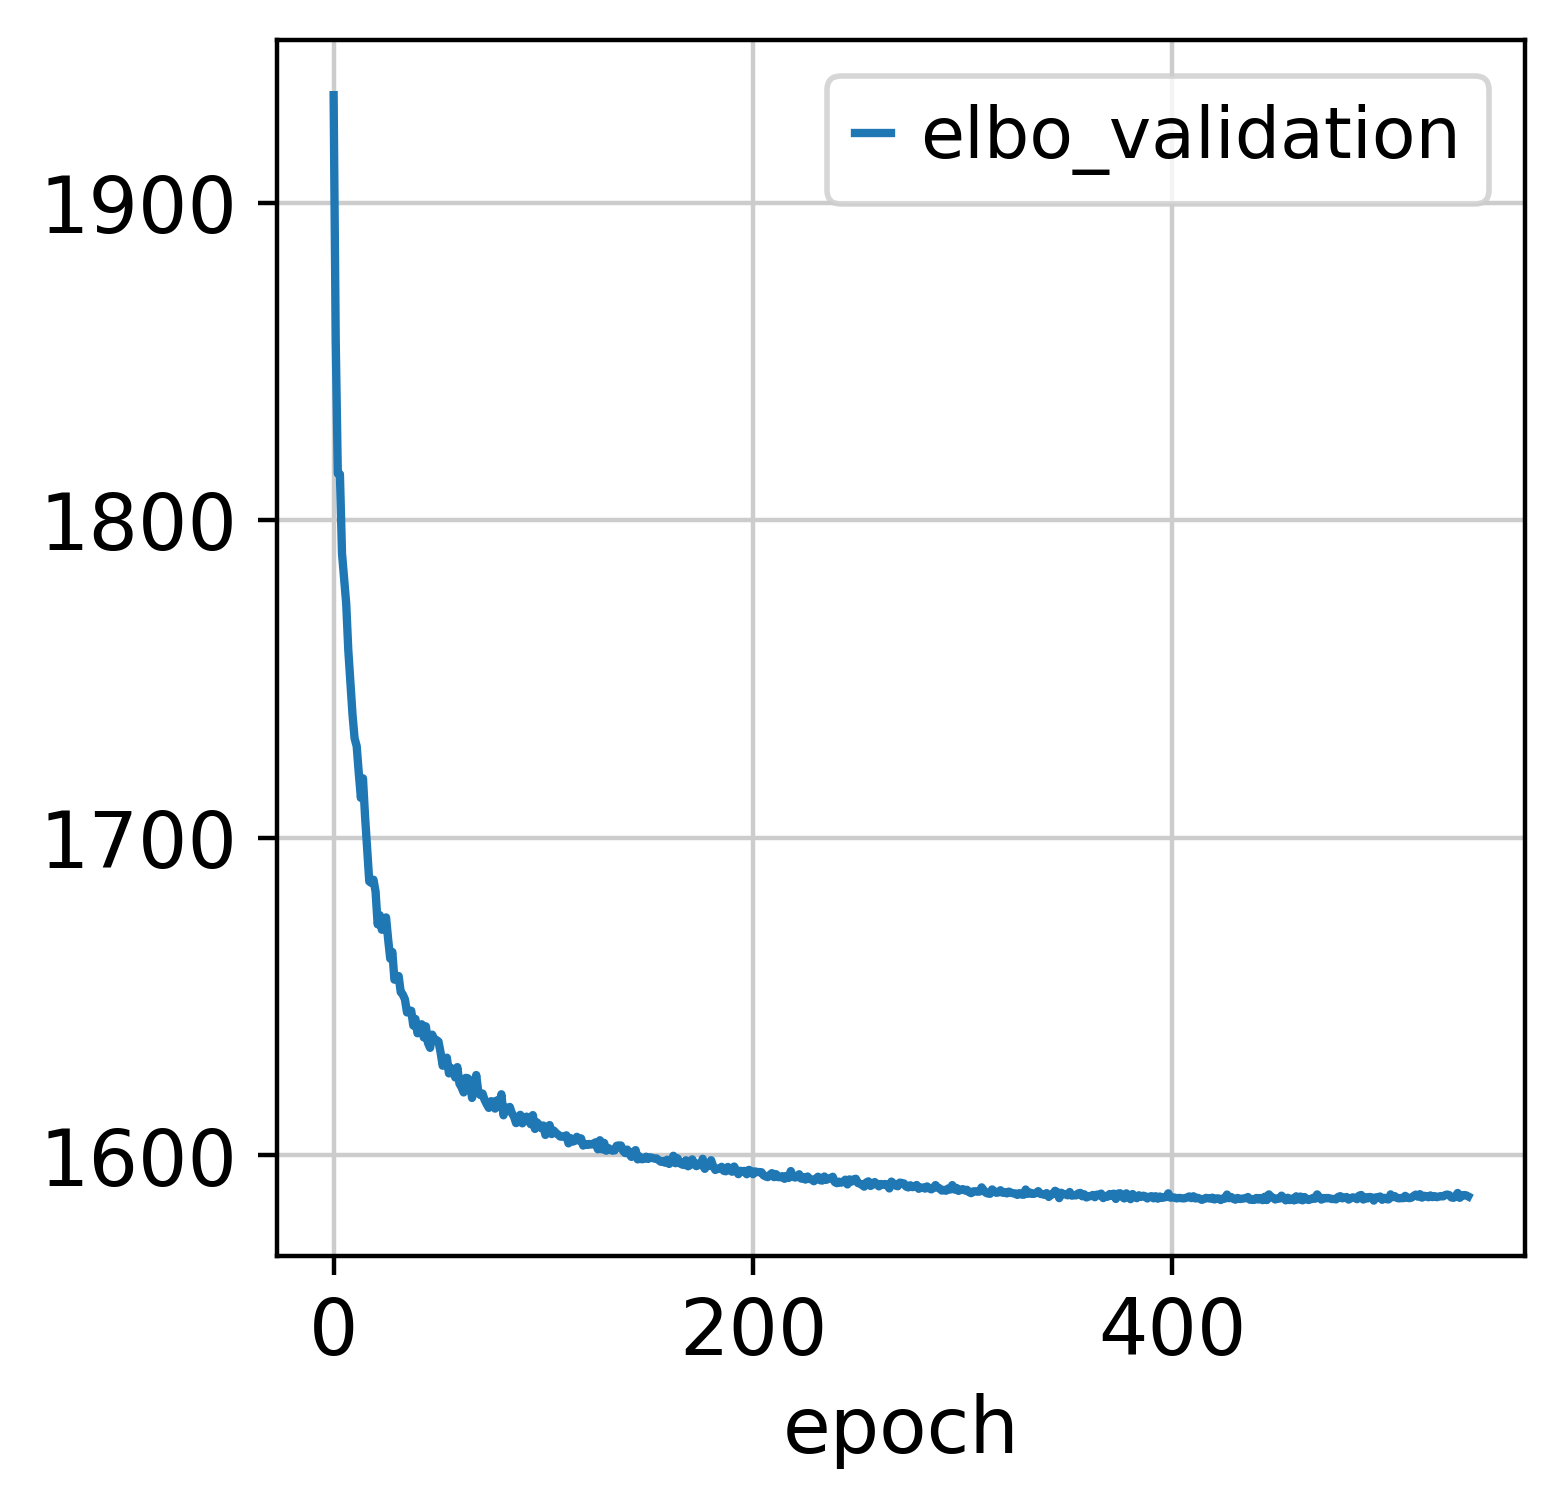

In [47]:
scvi_reference_model.history["elbo_validation"].plot()

In [48]:
SCVI_LATENT_KEY = "X_scVI"
reference_adata.obsm[SCVI_LATENT_KEY] = scvi_reference_model.get_latent_representation()

In [49]:
sc.pp.neighbors(
    adata = reference_adata, 
    use_rep = SCVI_LATENT_KEY, 
    n_neighbors = 15,
    n_pcs = 50
)
sc.tl.leiden(
    reference_adata,
    flavor = "igraph",
    resolution = 1,
    n_iterations = 10
)

In [50]:
SCVI_MDE_KEY = "X_scVI_MDE"
reference_adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(reference_adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              
Jul 10 10:50:22 AM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jul 10 10:50:22 AM: The following items have duplicates [3292 3506 3551 3966 4008 4067 4192 4404 4867 5171 6901 6972 7076 7173
 7235 7520 8083 8534 8758 9053]


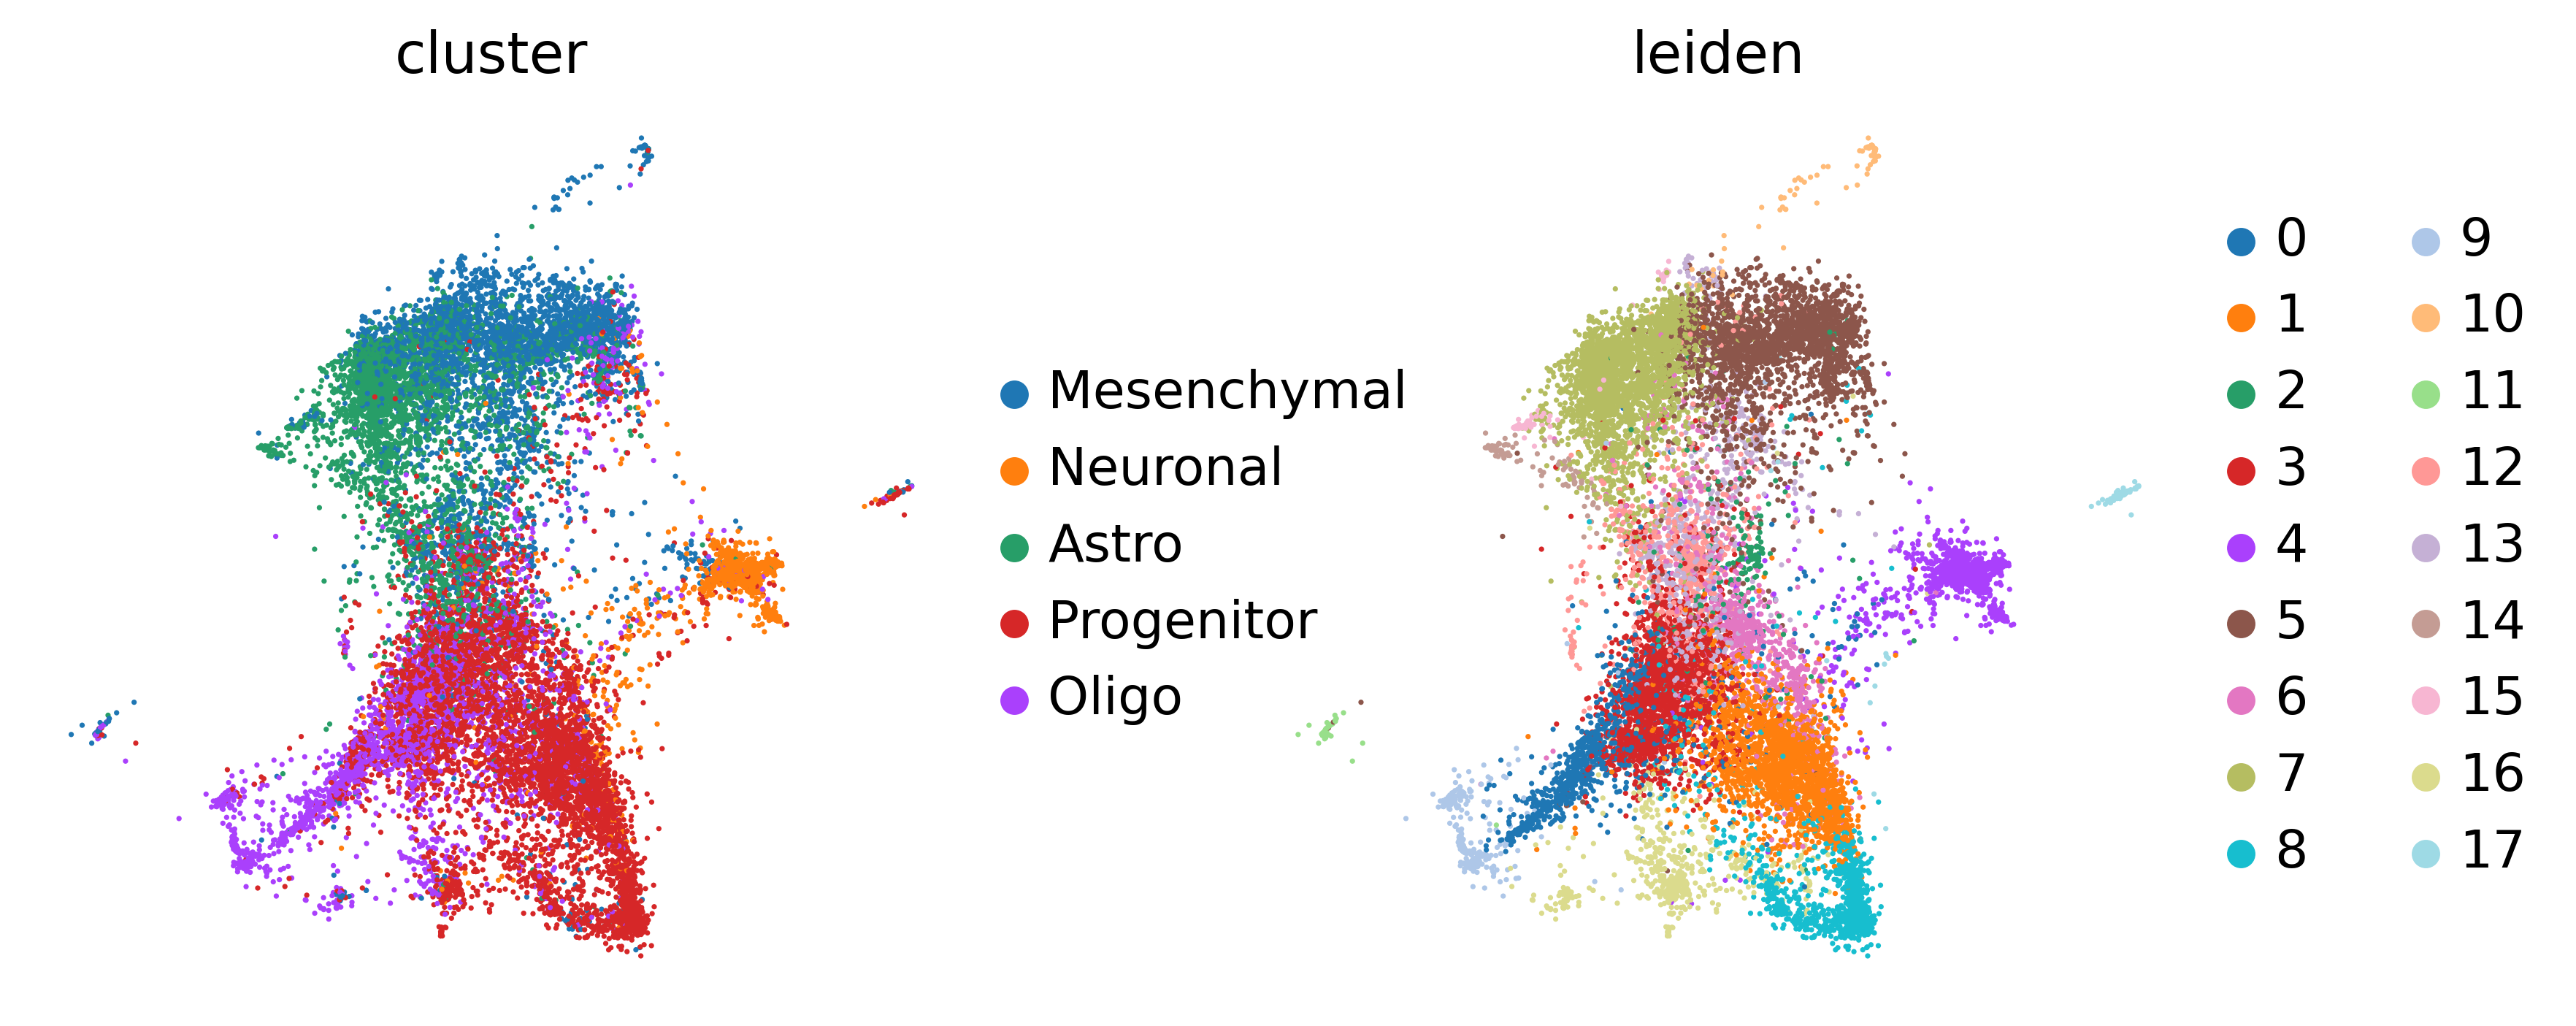

In [51]:
sc.pl.embedding(
    adata = reference_adata,
    basis = SCVI_MDE_KEY,
    color = ["sample", "leiden"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2,
)